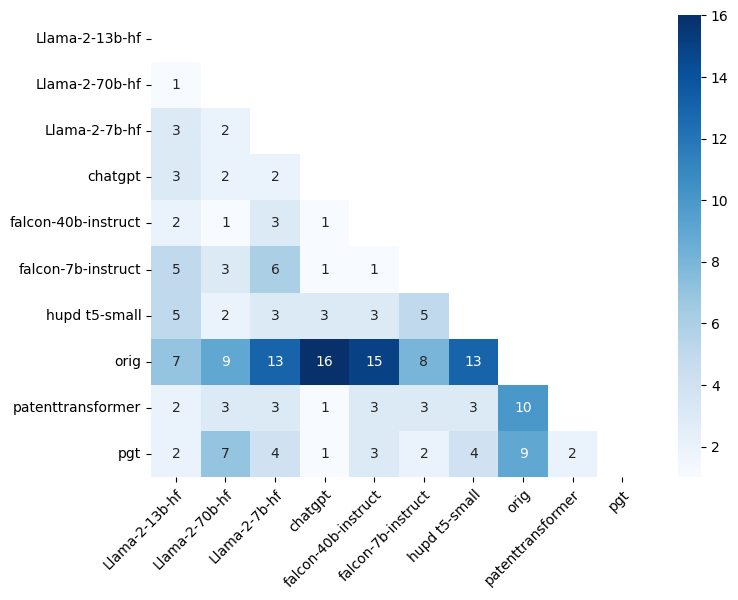

In [11]:
import json
import numpy as np
from collections import defaultdict

with open('./annotations/final_c2a.json') as f:  annotations = json.load(f)
with open('./preprocessed_for_annotation/selected_pairs_c2a.jsonl') as f:  model_info = [json.loads(line) for line in f]

# get model information from selected pairs
model_pairs = []
for model_selection in model_info:
    selections = list(model_selection.values())[0]
    assert len(selections) == 2
    for pair in selections:
        model_pairs.append(pair)

assert len(annotations) == len(model_pairs) # once finished, the length should be the same
model_pairs_annotated = model_pairs[:len(annotations)]
for i in range(len(model_pairs_annotated)):
    for j in [0,1]:
        if model_pairs_annotated[i][j] == "hupd":
            model_pairs_annotated[i][j] = "hupd t5-small"


# model frequency in selected pairs
model_freq = defaultdict(int)
for pair in model_pairs:
    model1, model2 = pair
    model_freq[model1] += 1
    model_freq[model2] += 1
model_freq = dict(model_freq)


# create matrix of model pairs
model_names = list(model_freq.keys())
model_names = sorted(model_names)
count_pairs = np.zeros((len(model_names), len(model_names)))
for pair in model_pairs:
    model1, model2 = pair
    
    count_pairs[model_names.index(model1), model_names.index(model2)] += 1
    count_pairs[model_names.index(model2), model_names.index(model1)] += 1


# plot the heatmap of model pairs, only show upper triangle of the matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(count_pairs, columns=model_names, index=model_names)
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 6))
sns.heatmap(df, mask=mask, annot=True, fmt='.0f', cmap='Blues')
# Adjust x-tick labels
plt.xticks(np.arange(len(model_names))+0.5, model_names, rotation=45, ha="right", rotation_mode='anchor')

plt.savefig('./figures/c2a_model1_model2', dpi=300)

## visualization of human annotations

In [12]:
with open('./annotations/final_c2a.json') as f:  annotated_data = json.load(f)

annotations = []
for annot in annotated_data:
    assert len(annot) > 0
    data_line = [annot["input_claim"], annot["output1"], annot["output2"]]
    preference = annot["comparison"][0]["selected"] if "comparison" in annot and "selected" in annot["comparison"][0] else "draw"

    errors = {}
    if "dimension1" not in annot:
        errors["dimension1"] = []
    elif "choices" in annot["dimension1"]:
        errors["dimension1"] = annot["dimension1"]["choices"]
    else:
        errors["dimension1"] = [annot["dimension1"]]

    if "dimension2" not in annot:
        errors["dimension2"] = []
    elif "choices" in annot["dimension2"]:
        errors["dimension2"] = annot["dimension2"]["choices"]
    else:
        errors["dimension2"] = [annot["dimension2"]]

    # annotations.append({"data": data_line, "preference": preference, "errors": errors})
    annotations.append({"preference": preference, "errors": errors})

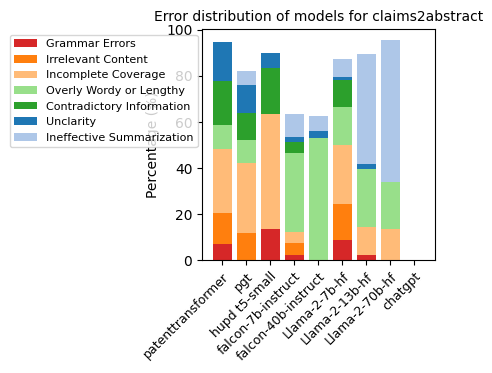

In [13]:
from collections import defaultdict

default_errors = ["Grammar Errors",
                  "Irrelevant Content (Deviation from Subject Matter)",
                  "Incomplete Coverage (Missing Key Components)",
                  "Overly Wordy or Lengthy (Inclusion of Unnecessary Details)",
                  "Contradictory Information (Factual Errors)",
                  "Unclarity (Vague or ambiguous descriptions)",
                  "Ineffective Summarization (replication of claims)"] + ["Correct"]
default_errors = {error.split("(")[0].strip(): 0 for error in default_errors}

# calculate the frequency of each error from previous defined errors
errors = defaultdict(lambda: default_errors.copy())

for (model1, model2), annot in zip(model_pairs_annotated, annotations):
    model1_correct, model2_correct = True, True

    for error in annot["errors"]["dimension1"]:
        errors[model1][error.split("(")[0].strip()] += 1
        model1_correct = False
    for error in annot["errors"]["dimension2"]:
        errors[model2][error.split("(")[0].strip()] += 1
        model2_correct = False

    # if both models are correct, add 1 to correct error
    if model1_correct:
        errors[model1]["Correct"] += 1
    if model2_correct:
        errors[model2]["Correct"] += 1



# sort the errors by model name, normalize the frequency of errors by sum of error frequency of each model
desired_order_list = ['patenttransformer',
                      'pgt',
                      'hupd t5-small',
                      'falcon-7b-instruct', 
                      'falcon-40b-instruct', 
                      'Llama-2-7b-hf',
                      'Llama-2-13b-hf', 
                      'Llama-2-70b-hf',
                      'chatgpt',
                      'orig']

errors = [(k, errors[k]) for k in desired_order_list]
errors = [(model, {error: freq / sum(error_freq.values()) for error, freq in error_freq.items()}) for model, error_freq in errors if model != "orig"]

# change "orig" to "human"
errors = [(model.replace("orig", "human"), error_freq) for model, error_freq in errors]

# # reorder model names by the frequency of correct
# errors = sorted(errors, key=lambda x: x[1]["Correct"], reverse=True)
############################################################################################################
# draw barchart of error ratio, remove "Correct" from error dictionary
import matplotlib.pyplot as plt
import numpy as np

# Define the Tableau 20 color palette
tableau20 = [
    "#d62728", "#ff7f0e", "#ffbb78", "#98df8a", "#2ca02c", "#1f77b4", "#aec7e8", 
     "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
]

# Fix size of the plot
plt.figure(figsize=(3, 3))

model_names, error_freqs = zip(*errors)
error_names = list(error_freqs[0].keys())

# Remove 'Correct' from error names for plotting
if 'Correct' in error_names:
    error_names.remove('Correct')

error_freqs = [[error_freq.get(error, 0) for error in error_names] for error_freq in error_freqs]
error_freqs = np.array(error_freqs)
# convert to percentage
error_freqs *= 100

bottom = np.zeros(len(model_names))
for i, error_name in enumerate(error_names):
    color = tableau20[i % len(tableau20)]  # Cycle through Tableau 20 colors
    plt.bar(model_names, error_freqs[:, i], bottom=bottom, label=error_name, color=color)
    bottom += error_freqs[:, i]

plt.xticks(rotation=45, ha="right", rotation_mode='anchor', fontsize=9)
plt.ylabel("Percentage (%)")
plt.title("Error distribution of models for claims2abstract", fontsize=10)

# put legend outside of the plot on the upper left
plt.legend(bbox_to_anchor=(-0.85, 1), loc='upper left', ncol=1, fontsize=8)
plt.savefig('./figures/c2a_error_ratio', dpi=300)

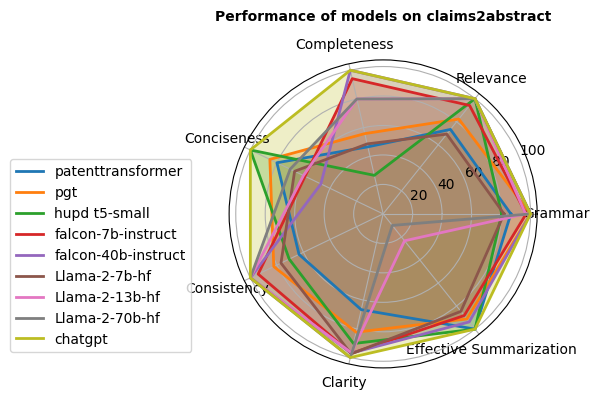

In [14]:
# calculate the frequency of each error from previous defined errors
errors = defaultdict(lambda: default_errors.copy())

for (model1, model2), annot in zip(model_pairs_annotated, annotations):
    model1_correct, model2_correct = True, True

    for error in annot["errors"]["dimension1"]:
        errors[model1][error.split("(")[0].strip()] += 1
        model1_correct = False
    for error in annot["errors"]["dimension2"]:
        errors[model2][error.split("(")[0].strip()] += 1
        model2_correct = False

    # if both models are correct, add 1 to correct error
    if model1_correct:
        errors[model1]["Correct"] += 1
    if model2_correct:
        errors[model2]["Correct"] += 1


# sort the errors by model name, normalize the frequency of errors by sum of error frequency of each model
desired_order_list = ['patenttransformer',
                      'pgt',
                      'hupd t5-small',
                      'falcon-7b-instruct', 
                      'falcon-40b-instruct', 
                      'Llama-2-7b-hf',
                      'Llama-2-13b-hf', 
                      'Llama-2-70b-hf',
                      'chatgpt',
                      'orig']

errors = [(k, errors[k]) for k in desired_order_list]
errors = [(model, {error: freq / model_freq[model] for error, freq in error_freq.items()}) for model, error_freq in errors if model != "orig"]



# Iterate through the errors data and calculate the complement (1 - error rate) for each error type except "Correct"
for i, (model, error_freq) in enumerate(errors):
    for error_type in error_freq:
        if error_type != "Correct":
            errors[i][1][error_type] = 1 - error_freq[error_type]

############################################################################################################
import matplotlib.pyplot as plt
import numpy as np

error_type_mapping = {
    "Grammar Errors": "Grammar",
    "Irrelevant Content": "Relevance",
    "Incomplete Coverage": "Completeness",
    "Overly Wordy or Lengthy": "Conciseness",
    "Contradictory Information": "Consistency",
    "Unclarity": "Clarity",
    # "Other": "Effective Summarization",
    "Ineffective Summarization": "Effective Summarization",
    # "Correct": "Perfection"  # Renamed to "Perfection"
}

# Iterate through the errors data and update error type names
for i, (model, error_freq) in enumerate(errors):
    updated_error_freq = {}
    for error_type, freq in error_freq.items():
        updated_error_type = error_type_mapping.get(error_type, error_type)
        updated_error_freq[updated_error_type] = freq
    errors[i] = (model, updated_error_freq)

errors = [(model, {error: round(freq * 100, 2) for error, freq in error_freq.items()}) for model, error_freq in errors]

# Define the error types
error_types = ["Grammar", "Relevance", "Completeness", "Conciseness", "Consistency", "Clarity", "Effective Summarization"]#, "Perfection"]

# Calculate the number of variables we're plotting.
num_vars = len(error_types)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is made circular, so we need to "complete the loop" and append the start to the end.
angles += angles[:1]

# Draw one axe per variable and add labels
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))

# Helper function to draw one model on the chart.
def draw_model(ax, angles, model_name, stats):
    # Plot data and fill with color
    stats += stats[:1]  # Complete the loop
    ax.plot(angles, stats, label=model_name, linewidth=2)
    ax.fill(angles, stats, alpha=0.25)

# Iterate through each model
for model, error_freq in errors:
    stats = [error_freq.get(error, 0) for error in error_types]
    draw_model(ax, angles, model, stats)

# Add attribute labels
ax.set_thetagrids(np.degrees(angles[:-1]), error_types, fontsize=10)

# Set the title of the chart
plt.title('Performance of models on claims2abstract', fontsize=10, y=1.1, fontweight='bold')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(-0.1, 0.7), fontsize=10)

# Show plot
plt.savefig('./figures/c2a_error_polar', dpi=300)


In [15]:
# calculate the ratio of win, lose for each model compared to human and other models
default_ratios = {"win": 0, "draw":0, "lose": 0}
compared_to_human = defaultdict(lambda: default_ratios.copy())
compared_to_models = defaultdict(lambda: default_ratios.copy())

for (model1, model2), annot in zip(model_pairs_annotated, annotations):
    if "orig" in [model1, model2]:
        if model1 == "orig":
            if annot["preference"] == "draw":
                compared_to_human[model2]["draw"] += 1

            elif annot["preference"] == "left":
                compared_to_human[model2]["lose"] += 1
            elif annot["preference"] == "right":
                compared_to_human[model2]["win"] += 1
            else:
                print("Error in preference", annot, "in pair", (model1, model2))
        elif model2 == "orig":
            if annot["preference"] == "draw":
                compared_to_human[model1]["draw"] += 1
            elif annot["preference"] == "left":
                compared_to_human[model1]["win"] += 1
            elif annot["preference"] == "right":
                compared_to_human[model1]["lose"] += 1
            else:
                print("Error in preference", annot, "in pair", (model1, model2))
    else:
        if annot["preference"] == "draw":
            compared_to_models[model1]["draw"] += 1

        elif annot["preference"] == "left":
            compared_to_models[model1]["win"] += 1
            compared_to_models[model2]["lose"] += 1
        elif annot["preference"] == "right":
            compared_to_models[model1]["lose"] += 1
            compared_to_models[model2]["win"] += 1
        else:
            print("Error in preference", annot, "in pair", (model1, model2))

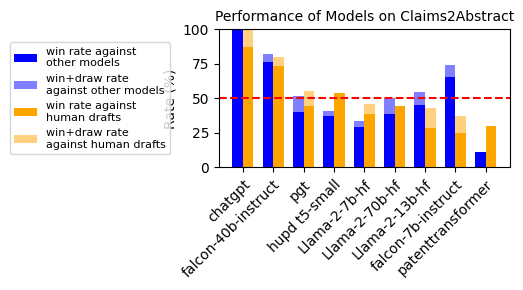

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'compared_to_models' and 'compared_to_human' contain 'win', 'draw', and 'loss' keys
# Normalize and calculate win+draw rates
normalized_models = {model: {'win': freqs['win'] / sum(freqs.values()), 
                             'draw': freqs['draw'] / sum(freqs.values())} 
                             for model, freqs in compared_to_models.items()}

normalized_human = {model: {'win': freqs['win'] / sum(freqs.values()), 
                            'draw': freqs['draw'] / sum(freqs.values())} 
                            for model, freqs in compared_to_human.items()}

# Sort models based on combined win+draw rate compared to human
sorted_models = sorted(normalized_human.items(), key=lambda x: x[1]['win'] + x[1]['draw'], reverse=True)
sorted_model_names = [model for model, _ in sorted_models]

# Extract the sorted win and draw rates
win_rates_models = [normalized_models[model]['win'] for model in sorted_model_names]
draw_rates_models = [normalized_models[model]['draw'] for model in sorted_model_names]

win_rates_human = [normalized_human[model]['win'] for model in sorted_model_names]
draw_rates_human = [normalized_human[model]['draw'] for model in sorted_model_names]

# Convert the normalized rates to percentages
win_rates_models = [rate * 100 for rate in win_rates_models]
draw_rates_models = [rate * 100 for rate in draw_rates_models]
win_rates_human = [rate * 100 for rate in win_rates_human]
draw_rates_human = [rate * 100 for rate in draw_rates_human]

#############################################################################################

barWidth = 0.35
r1 = np.arange(len(sorted_model_names))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(5.5, 3))

# Define colors and alpha for transparency
color_model = 'b'  # Blue for models
color_human = 'orange'  # Orange for humans
alpha_draw = 0.5  # Transparency for draw rate

# Plot bars for models and humans, with wins solid and draws transparent
plt.bar(r1, win_rates_models, color=color_model, width=barWidth, label='Model Win Rate')
plt.bar(r1, draw_rates_models, bottom=win_rates_models, color=color_model, width=barWidth, alpha=alpha_draw, label='Model Draw Rate')
plt.bar(r2, win_rates_human, color=color_human, width=barWidth, label='Human Win Rate')
plt.bar(r2, draw_rates_human, bottom=win_rates_human, color=color_human, width=barWidth, alpha=alpha_draw, label='Human Draw Rate')

# Add a reference line at 50% for clarity
plt.axhline(y=50, color='r', linestyle='--', label="Equilibrium Rate")

# Set the position of the x ticks and labels
plt.xticks([r + barWidth / 2 for r in r1], sorted_model_names, rotation=45, ha="right", rotation_mode='anchor')
plt.ylabel("Rate (%)")
plt.title("Performance of Models on Claims2Abstract", fontsize=10)

# Create the legend with clear descriptions
handles, labels = plt.gca().get_legend_handles_labels()
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=color_model, label='win rate against\nother models'),
    Patch(facecolor=color_model, alpha=alpha_draw, label='win+draw rate\nagainst other models'),
    Patch(facecolor=color_human, label='win rate against\nhuman drafts'),
    Patch(facecolor=color_human, alpha=alpha_draw, label='win+draw rate\nagainst human drafts')
]
plt.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(-0.15, 0.5), fontsize=8)


plt.tight_layout()
plt.savefig('./figures/c2a_win_percent', dpi=300)
plt.show()


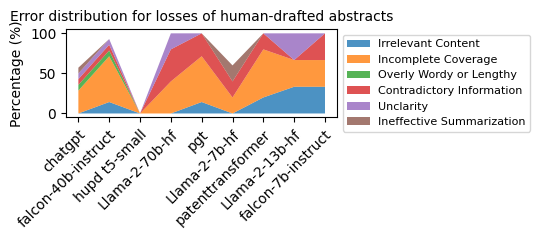

In [17]:
target_model = "orig"
stats = defaultdict(lambda: {"win+draw": 0, "lose": 0}) # count win+draw and lose to each other model
hints = {model: defaultdict(int) for model in model_freq.keys()} # every time the target model loses, count the error type that causes the loss

# count the win+draw and lose rate for each model
for (model1, model2), annot in zip(model_pairs_annotated, annotations):
    if model1 == target_model:
        if annot["preference"] == "draw":
            stats[model2]["win+draw"] += 1
        elif annot["preference"] == "right":
            stats[model2]["lose"] += 1
            for error in annot["errors"]["dimension1"]: # count the error type that causes the loss 
                hints[model2][error.split("(")[0].strip()] += 1
            if len(annot["errors"]["dimension1"]) == 0:
                hints[model2]["Correct"] += 1
                
        elif annot["preference"] == "left":
            stats[model2]["win+draw"] += 1
        else:
            print("Error in preference", annot, "in pair", (model1, model2))

    elif model2 == target_model:
        if annot["preference"] == "draw":
            stats[model1]["win+draw"] += 1
        elif annot["preference"] == "right":
            stats[model1]["win+draw"] += 1
        elif annot["preference"] == "left":
            stats[model1]["lose"] += 1
            for error in annot["errors"]["dimension2"]:
                hints[model1][error.split("(")[0].strip()] += 1
            if len(annot["errors"]["dimension2"]) == 0:
                hints[model1]["Correct"] += 1
        else:
            print("Error in preference", annot, "in pair", (model1, model2))

# normalize the win+draw and lose rate by the total number of comparison
stats = {model: {"win+draw": stats[model]["win+draw"] / (stats[model]["win+draw"] + stats[model]["lose"]),
                    "lose": stats[model]["lose"] / (stats[model]["win+draw"] + stats[model]["lose"])} for model in stats}

# sort the models by lose rate
sorted_models = sorted(stats.items(), key=lambda x: x[1]["lose"], reverse=True)
sorted_model_names = [model for model, _ in sorted_models]

# normalize the error hints by the total number of errors towards each model\
hints = {model.replace("hupd","hupd t5-small"): {error: hints[model][error] / sum(hints[model].values()) for error in hints[model]} for model in hints}

# Define your predefined list of error types
predefined_error_types = [
    "Grammar Errors", "Irrelevant Content", "Incomplete Coverage",
    "Overly Wordy or Lengthy", "Contradictory Information",
    "Unclarity", "Ineffective Summarization"
]

# Normalize the error hints for each model and convert to percentage
normalized_hints = defaultdict(dict)
for model, error_counts in hints.items():
    total_errors = sum(error_counts.values())
    for error, count in error_counts.items():
        if error in predefined_error_types:  # Only include predefined error types
            normalized_hints[model][error] = (count / total_errors * 100) if total_errors > 0 else 0

# Filter out any error types in 'hints' that are not in 'predefined_error_types'
actual_error_types = set.intersection(set(predefined_error_types), set(sum([list(h.keys()) for h in hints.values()], [])))

# Ensure the order of error types is maintained as in predefined_error_types
filtered_error_types = [et for et in predefined_error_types if et in actual_error_types]

plt.figure(figsize=(5.5, 2.5))
cumulative_data = np.zeros(len(sorted_model_names))

# Build the cumulative data for the stackplot for filtered error types
for error_type in filtered_error_types:
    error_percentage = [normalized_hints[model].get(error_type, 0) for model in sorted_model_names]
    cumulative_data = np.add(cumulative_data, error_percentage)
    plt.fill_between(sorted_model_names, cumulative_data, cumulative_data - error_percentage, label=error_type, alpha=0.8)

plt.xticks(rotation=45, ha="right", rotation_mode='anchor')
plt.ylabel("Percentage (%)")
plt.title(f"Error distribution for losses of human-drafted abstracts", fontsize=10)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize=8)
plt.tight_layout()
plt.savefig(f'./figures/{target_model}_loss_analysis.png', dpi=300)
plt.show()